In [1]:
import os
import math
import random
import cv2
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
import numpy as np
import random
seed_constant = 0
np.random.seed(seed_constant)
random.seed(seed_constant)

ucf50 dataset (https://www.crcv.ucf.edu/data/UCF50.php)

50 actions, 133 avg. videos per action category, 199 avg. # frames per video,
 320 x 240 frame size, 26 fps

['Stage 4', 'Stage 3', 'Stage 2', 'Stage 5', 'Stage 7', 'Stage 6', 'Stage 1', 'Stage 8']


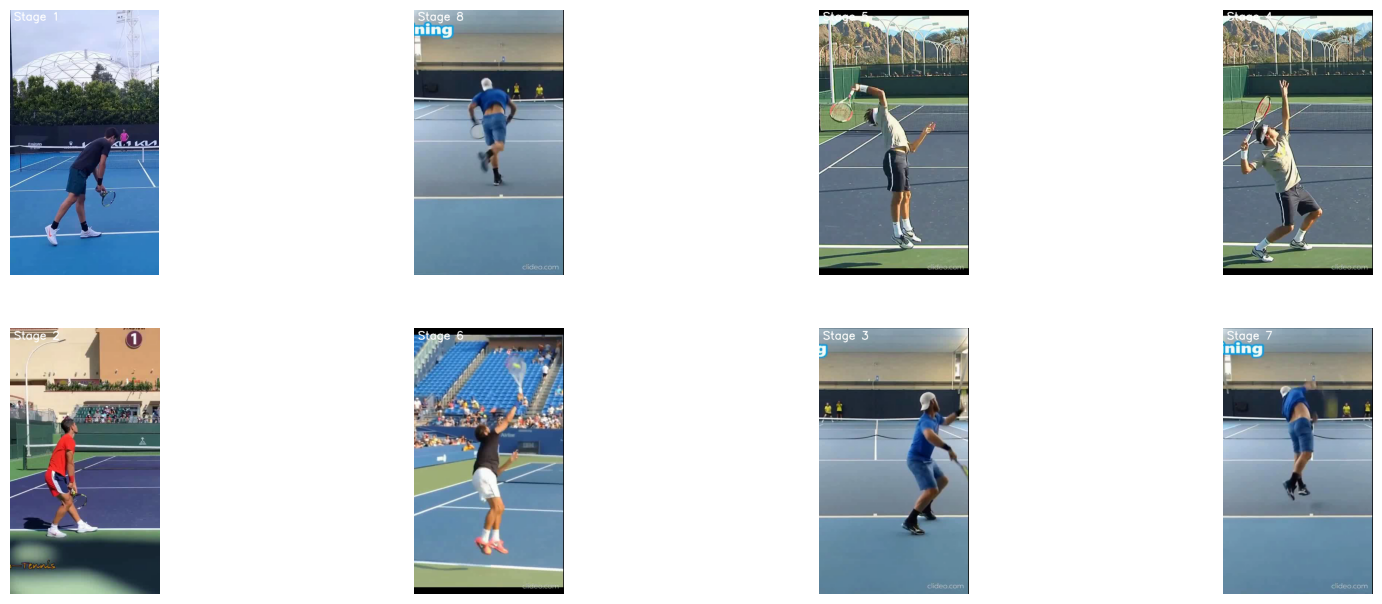

In [5]:
import matplotlib.pyplot as plt
import os
import cv2
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
# print(os.listdir('./RData/'))
all_classes_names = os.listdir('./RData')
all_classes_names.remove('.DS_Store')
all_classes_names.remove('RStages-Ann')
all_classes_names.remove('RTennisServes')
all_classes_names.remove('dataset.csv')
print(all_classes_names)

random_range = random.sample(range(len(all_classes_names)), 8)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'RData/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'RData/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

## **<font style="color:rgb(134,19,348)">Step 2: Preprocess the Dataset</font>**

Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range `[0-1]` by dividing the pixel values with `255`, which makes convergence faster while training the network.

*But first, let's initialize some constants.*

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 114

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 79

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "dataset/"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Stage 1", "Stage 2", "Stage 3", "Stage 4", "Stage 5", "Stage 6", "Stage 7", "Stage 8"]

frame_extraction function - resizes + normalizes frames of a video (skips over frames)

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        current_frame_pos = frame_counter * skip_frames_window
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, current_frame_pos)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # If the desired frame count is not reached, add blank frames to meet the count
    while len(frames_list) < SEQUENCE_LENGTH:
        blank_frame = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3))  # Create a blank frame
        frames_list.append(blank_frame / 255)  # Append the normalized blank frame

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

create dataset


In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Stage 1
Extracting Data of Class: Stage 2


KeyboardInterrupt: ignored

In [ ]:
features

array([[array([[[0.91764706, 0.8       , 0.74901961],
                [0.91764706, 0.8       , 0.74901961],
                [0.91764706, 0.8       , 0.74901961],
                ...,
                [0.98431373, 0.85882353, 0.83529412],
                [0.98431373, 0.85882353, 0.83529412],
                [0.98431373, 0.85882353, 0.83529412]],

               [[0.92941176, 0.81176471, 0.76078431],
                [0.91764706, 0.8       , 0.74901961],
                [0.91764706, 0.8       , 0.74901961],
                ...,
                [0.98431373, 0.85882353, 0.83529412],
                [0.98431373, 0.85882353, 0.83529412],
                [0.98431373, 0.85882353, 0.83529412]],

               [[0.9254902 , 0.81176471, 0.76078431],
                [0.91764706, 0.8       , 0.75294118],
                [0.91764706, 0.8       , 0.75294118],
                ...,
                [0.98431373, 0.85882353, 0.82745098],
                [0.98431373, 0.85882353, 0.82745098],
               

class indexes to one-hot-encoded vectors

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)


split & shuffle data

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
features_train

array([[array([[[0.        , 0.        , 0.        ],
                [0.        , 0.        , 0.        ],
                [0.        , 0.        , 0.        ],
                ...,
                [0.        , 0.        , 0.        ],
                [0.        , 0.        , 0.        ],
                [0.        , 0.        , 0.        ]],

               [[0.        , 0.        , 0.        ],
                [0.        , 0.        , 0.        ],
                [0.        , 0.        , 0.        ],
                ...,
                [0.        , 0.        , 0.        ],
                [0.        , 0.        , 0.        ],
                [0.        , 0.        , 0.        ]],

               [[0.01176471, 0.        , 0.        ],
                [0.01176471, 0.        , 0.        ],
                [0.00784314, 0.        , 0.        ],
                ...,
                [0.00392157, 0.        , 0.        ],
                [0.00392157, 0.        , 0.        ],
               

In this step, we will implement the first approach by using a combination of ConvLSTM cells. A ConvLSTM cell is a variant of an LSTM network that contains convolutions operations in the network. it is an LSTM with convolution embedded in the architecture, which makes it capable of identifying spatial features of the data while keeping into account the temporal relation.

<center>
<img src="https://drive.google.com/uc?export=view&id=1KHN_JFWJoJi1xQj_bRdxy2QgevGOH1qP" width= 500px>
</center>


For video classification, this approach effectively captures the spatial relation in the individual frames and the temporal relation across the different frames. As a result of this convolution structure, the ConvLSTM is capable of taking in 3-dimensional input `(width, height, num_of_channels)` whereas a simple LSTM only takes in 1-dimensional input hence an LSTM is incompatible for modeling Spatio-temporal data on its own.

https://arxiv.org/abs/1506.04214v1


### **<font style="color:rgb(134,19,348)">Step 4.1: Construct the Model</font>**


To construct the model, we will use Keras [**`ConvLSTM2D`**](https://keras.io/api/layers/recurrent_layers/conv_lstm2d) recurrent layers. The **`ConvLSTM2D`** layer also takes in the number of filters and kernel size required for applying the convolutional operations. The output of the layers is flattened in the end and is fed to the **`Dense`** layer with softmax activation which outputs the probability of each action category.

We will also use **`MaxPooling3D`** layers to reduce the dimensions of the frames and avoid unnecessary computations and **`Dropout`** layers to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) the model on the data. The architecture is a simple one and has a small number of trainable parameters. This is because we are only dealing with a small subset of the dataset which does not require a large-scale model.

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

Now we will utilize the function **`create_convlstm_model()`** created above, to construct the required `convlstm` model.

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 79, 133, 238, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 79, 67, 119, 4)    0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 79, 67, 119, 4)    0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 79, 65, 117, 8)    3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 79, 33, 59, 8)     0         
 g3D)                                                            
                                                        

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**


Now we will use the **`plot_model()`** function, to check the structure of the constructed model, this is helpful while constructing a complex network and making that the network is created correctly.

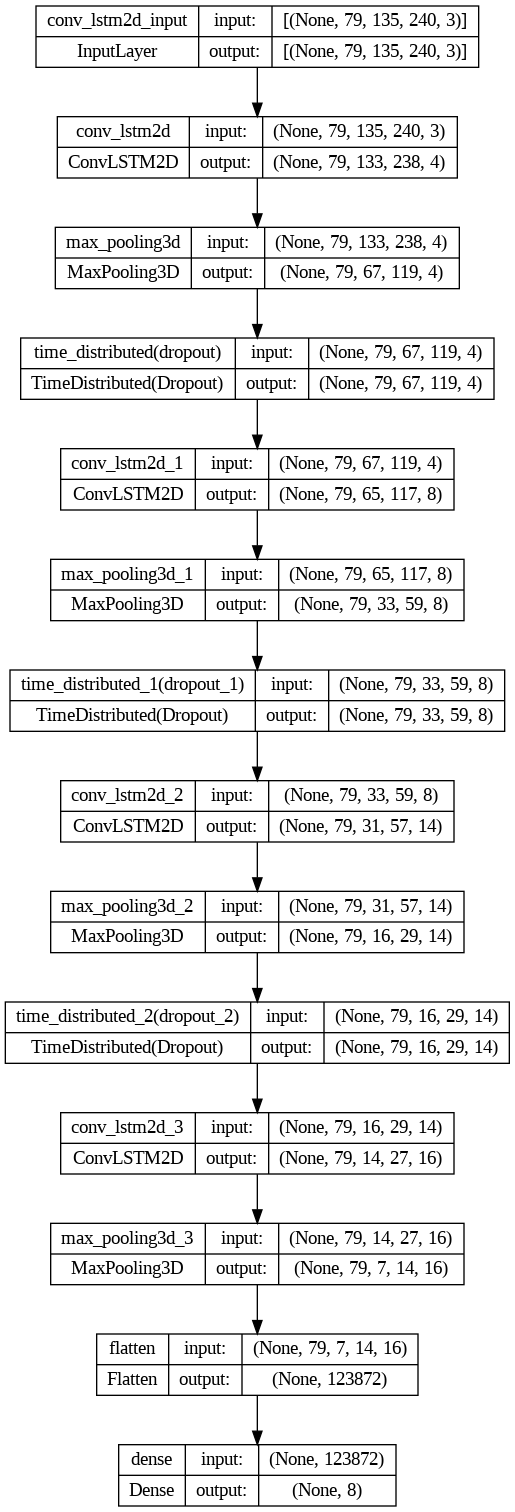

In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 4.2: Compile & Train the Model</font>**

Next, we will add an early stopping callback to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) and start the training after compiling the model.

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 10, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

ValueError: ignored

#### **<font style="color:rgb(134,19,348)">Evaluate the Trained Model</font>**

After training, we will evaluate the model on the test set.

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

5/5 [==============================] - 1s 110ms/step - loss: 0.2150 - accuracy: 0.9514


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

Now we will save the model to avoid training it from scratch every time we need the model.

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

  saving_api.save_model(



### **<font style="color:rgb(134,19,348)">Step 4.3: Plot Model’s Loss & Accuracy Curves</font>**


Now we will create a function **`plot_metric()`** to visualize the training and validation metrics. We already have separate metrics from our training and validation steps so now we just have to visualize them.

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

Now we will utilize the function **`plot_metric()`** created above, to visualize and understand the metrics.

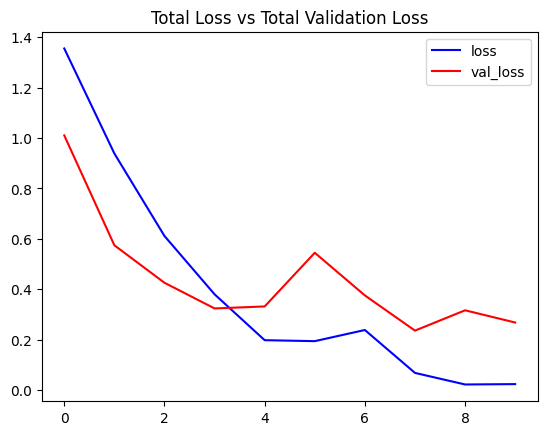

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

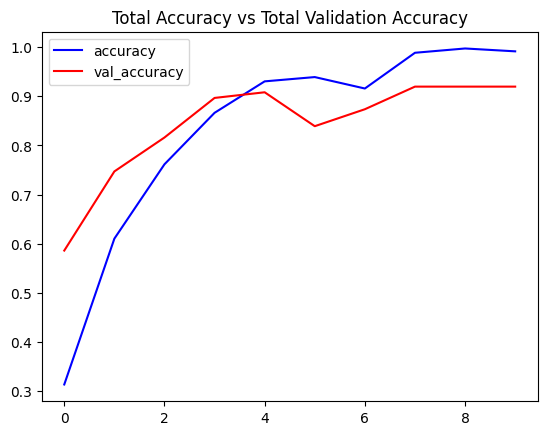

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## **<font style="color:rgb(134,19,348)">Step 5: Implement the LRCN Approach</font>**

In this step, we will implement the LRCN Approach by combining Convolution and LSTM layers in a single model. Another similar approach can be to use a CNN model and LSTM model trained separately. The CNN model can be used to extract spatial features from the frames in the video, and for this purpose, a pre-trained model can be used, that can be fine-tuned for the problem. And the LSTM model can then use the features extracted by CNN, to predict the action being performed in the video.


But here, we will implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

<center>
<img src='https://drive.google.com/uc?export=download&id=1I-q5yLsIoNh2chfzT7JYvra17FsXvdme'>
</center>


You can read the paper [Long-term Recurrent Convolutional Networks for Visual Recognition and Description](https://arxiv.org/abs/1411.4389?source=post_page---------------------------) by Jeff Donahue (CVPR 2015), to learn more about this architecture.

We will also use [**`TimeDistributed`**](https://keras.io/api/layers/recurrent_layers/time_distributed/) wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape `(no_of_frames, width, height, num_of_channels)` if originally the layer's input shape was `(width, height, num_of_channels)` which is very beneficial as it allows to input the whole video into the model in a single shot.

<center>
<img src='https://drive.google.com/uc?export=download&id=1CbauSm5XTY7ypHYBHH7rDSnJ5LO9CUWX' width=400>
</center>

### **<font style="color:rgb(134,19,348)">Step 5.1: Construct the Model</font>**

To implement our LRCN architecture, we will use time-distributed **`Conv2D`** layers which will be followed by **`MaxPooling2D`** and **`Dropout`** layers. The feature extracted from the **`Conv2D`** layers will be then flattened using the  **`Flatten`** layer and will be fed to a **`LSTM`** layer. The **`Dense`** layer with softmax activation will then use the output from the **`LSTM`** layer to predict the action being performed.

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDi  (None, 79, 64, 114, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 79, 16, 28, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 79, 16, 28, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 79, 16, 28, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 79, 4, 7, 32)     

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

Now we will use the **`plot_model()`** function to check the structure of the constructed `LRCN` model. As we had checked for the previous model.

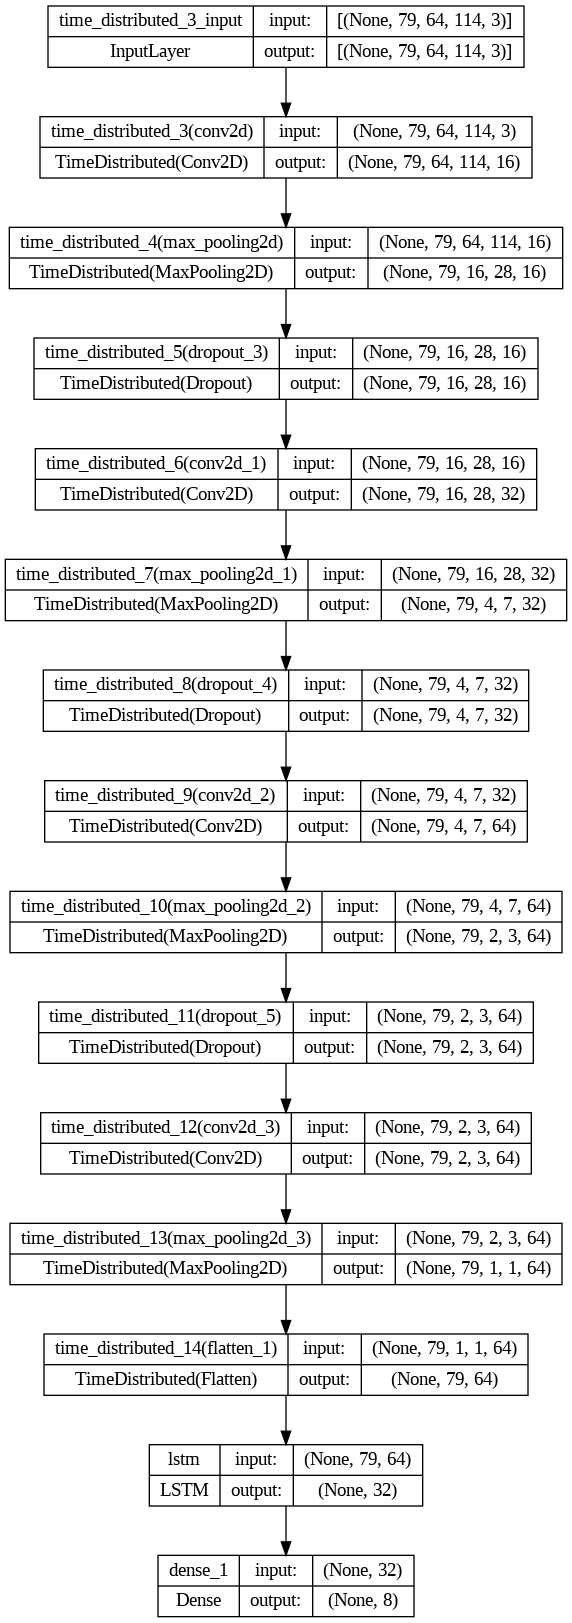

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 5.2: Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 10, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

ValueError: ignored

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

As done for the previous one, we will evaluate the `LRCN` model on the test set.

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 2s 418ms/step - loss: 0.2242 - accuracy: 0.9262


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

After that, we will save the model for future uses using the same technique we had used for the previous model.

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Step 5.3: Plot Model’s Loss & Accuracy Curves</font>**

Now we will utilize the function **`plot_metric()`** we had created above to visualize the training and validation metrics of this model.


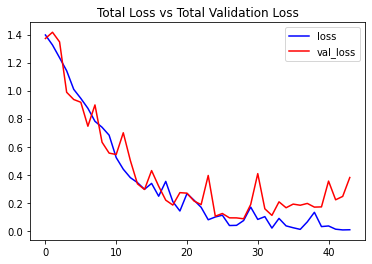

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

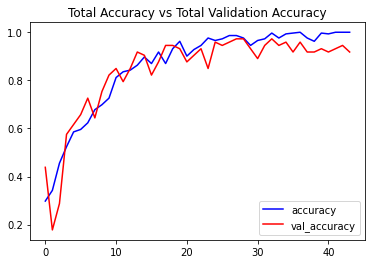

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## **<font style="color:rgb(134,19,348)">Step 6: Test the Best Performing Model on YouTube videos</font>**

From the results, it seems that the LRCN model performed significantly well for a small number of classes. so in this step, we will put the `LRCN` model to test on some youtube videos.

### **<font style="color:rgb(134,19,348)">Create a Function to Download YouTube Videos:</font>**

We will create a function **`download_youtube_videos()`** to download the YouTube videos first using **`pafy`** library. The library only requires a URL to a video to download it along with its associated metadata like the title of the video.

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''

     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)

     # Retrieve the title of the video.
     title = video.title

     # Get the best available quality object for the video.
     video_best = video.getbest()

     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'

     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)

     # Return the video title.
     return title

### **<font style="color:rgb(134,19,348)">Download a Test Video:</font>**

Now we will utilize the function **`download_youtube_videos()`** created above to download a youtube video on which the `LRCN` model will be tested.

In [ ]:
pip install --upgrade youtube_dl


In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=rj6rJzs029A', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


OSError: ignored

### **<font style="color:rgb(134,19,348)">Create a Function To Perform Action Recognition on Videos</font>**

Next, we will create a function **`predict_on_video()`** that will simply read a video frame by frame from the path passed in as an argument and will perform action recognition on video and save the results.

In [ ]:
from keras.models import load_model
LRCN_model = load_model('/content/model')
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

### **<font style="color:rgb(134,19,348)">Perform Action Recognition on the Test Video</font>**

Now we will utilize the function **`predict_on_video()`** created above to perform action recognition on the test video we had downloaded using the function **`download_youtube_videos()`** and display the output video with the predicted action overlayed on it.

In [ ]:
video_title = "basketball.mp4"
input_video_file_path = "test_videos/basketball.mp4"
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 56ms/step


KeyboardInterrupt: ignored

### **<font style="color:rgb(134,19,348)">Create a Function To Perform a Single Prediction on Videos</font>**


Now let's create a function that will perform a single prediction for the complete videos. We will extract evenly distributed **N** **`(SEQUENCE_LENGTH)`** frames from the entire video and pass them to the `LRCN` model. This approach is really useful when you are working with videos containing only one activity as it saves unnecessary computations and time in that scenario.  

In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    # Release the VideoCapture object.
    video_reader.release()

### **<font style="color:rgb(134,19,348)">Perform Single Prediction on a Test Video</font>**

Now we will utilize the function **`predict_single_action()`** created above to perform a single prediction on a complete youtube test video that we will download using the function **`download_youtube_videos()`**, we had created above.

In [ ]:
# Construct tihe nput youtube video path
input_video_file_path = '/content/dataset/UCF50/TennisSwing/v_TennisSwing_g23_c06.avi'

# Perform Single Prediction on the Test Video.
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

# Display the input video.
VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 55ms/step
Action Predicted: TennisSwing
Confidence: 0.9980455636978149
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  57%|█████▋    | 43/75 [00:00<00:00, 426.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/dataset/UCF50/TennisSwing/v_TennisSwing_g23_c06.avi, 360000 bytes wanted but 0 bytes read,at frame 74/75, at time 2.47/2.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                             

Moviepy - Done !
Moviepy - video ready __temp__.mp4


#  <center> <font style="color:rgb(234,19,148)">Join My Upcoming Computer Vision For Building Cutting Edge Applications Course</font>   </center>

A Course that goes beyond basic applications and teaches you how to create some next-level apps that utilize physics, deep learning (LSTM + CNN) + classical image processing, hand and body gestures to do a variety of very interesting things.
<center>
<img src='https://drive.google.com/uc?export=download&id=1GYO8Rg6l1ClLmEtPQz7Mwve-aSt9vvId'></center>

<br>
<br>

<center>  <a href="https://www.getdrip.com/forms/677961673/submissions/new"> <button>Join the Waitlist!</button>
</a></center>
    
